In [1]:
import sys
sys.path.append("/Colorization/src")  # Append path to src
import time
import numpy as np

import torch
from networks.dataset import get_dataset_prior_probs

In [2]:
def ab_orig_transform(img_rgb_orig, target):
    img_lab_orig = color.rgb2lab(img_rgb_orig)
    img_ab_orig = np.moveaxis(img_lab_orig[...,1:], -1, 0)  # (2, H, W)
    return (img_lab_orig, img_ab_orig)

def load_dataset(root, annFile, batch_size):
    dataset = dset.CocoDetection(root=root,
                                 annFile=annFile,
                                 transforms=ab_orig_transform)
    dataloader = data.DataLoader(dataset, batch_size=batch_size)
    return dataloader

In [3]:
val_root = '/Colorization/data/val2017'
val_annFile = '/Colorization/data/annotations/instances_val2017.json'
batch_size = 16
ab_gamut_filepath = '/Colorization/data/pts_in_hull.npy'
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

prior_probs = get_dataset_prior_probs(val_root, val_annFile, batch_size,
                                      ab_gamut_filepath, pytorch_device)
torch.cuda.empty_cache()

Found existing prior probs, won't regenerate it


In [3]:
root = '/Colorization/data/train2017'
annFile = '/Colorization/data/annotations/instances_train2017.json'
batch_size = 16
ab_gamut_filepath = '/Colorization/data/pts_in_hull.npy'
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

prior_probs = get_dataset_prior_probs(root, annFile, batch_size,
                                      ab_gamut_filepath, pytorch_device)
torch.cuda.empty_cache()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ivsg37rg because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Generating prior probability of dataset 'train2017' ...
loading annotations into memory...
Done (t=10.30s)
creating index...
index created!


100%|██████████| 7393/7393 [1:22:57<00:00,  1.49it/s]


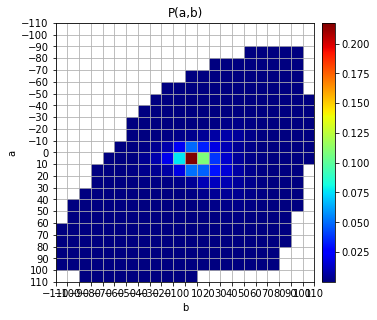

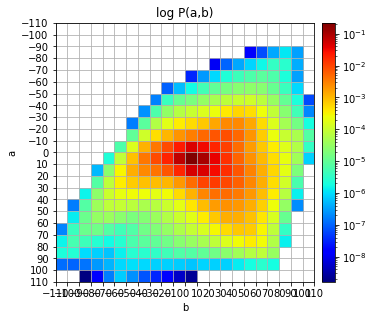

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
ab_grids = np.load(ab_gamut_filepath) 

W = H = 10

cmap = cm.get_cmap('jet')

norm = colors.Normalize(vmin=prior_probs.min(),
                        vmax=prior_probs.max(),
                        clip=True)

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i in range(ab_grids.shape[0]):
    rect = patches.Rectangle((ab_grids[i,1], ab_grids[i,0]), W, H,
                             color=m.to_rgba((prior_probs[i])))
    ax.add_patch(rect)

#ax.invert_yaxis()
ax.set_xlim([-110, 110]); ax.set_ylim([110, -110])
#ax.set_xticks([-110,-55,0,55,110]); ax.set_yticks([110,55,0,-55,-110])
ax.set_xticks(np.arange(-110,111,10)); ax.set_yticks(np.arange(110,-111,-10))
ax.set_xlabel('b'); ax.set_ylabel('a')
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.set_title('P(a,b)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(m, cax=cax)

plt.show()

## LogNorm
norm = colors.LogNorm(vmin=prior_probs.min()+1e-25,
                      vmax=prior_probs.max(),
                      clip=True)

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i in range(ab_grids.shape[0]):
    rect = patches.Rectangle((ab_grids[i,1], ab_grids[i,0]), W, H,
                             color=m.to_rgba((prior_probs[i])))
    ax.add_patch(rect)

#ax.invert_yaxis()
ax.set_xlim([-110, 110]); ax.set_ylim([110, -110])
#ax.set_xticks([-110,-55,0,55,110]); ax.set_yticks([110,55,0,-55,-110])
ax.set_xticks(np.arange(-110,111,10)); ax.set_yticks(np.arange(110,-111,-10))
ax.set_xlabel('b'); ax.set_ylabel('a')
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.set_title('log P(a,b)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(m, cax=cax)

plt.show()

Text(0, 0.5, 'P(a,b)')

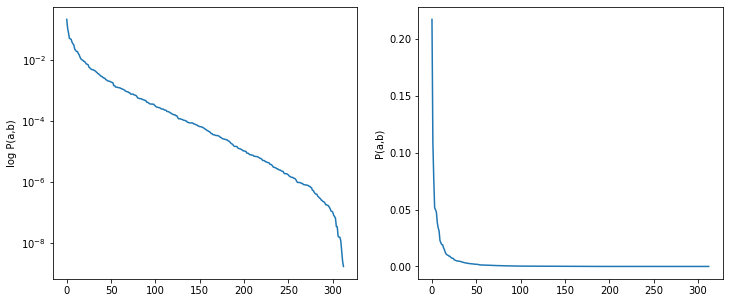

In [5]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)

ax.plot(np.sort(prior_probs)[::-1])
ax.set_yscale('log')
ax.set_ylabel('log P(a,b)')

ax = fig.add_subplot(122)

ax.plot(np.sort(prior_probs)[::-1])
ax.set_ylabel('P(a,b)')

## Compute Prior Probs (GPU)

In [1]:
import sys
sys.path.append("/Colorization/src")  # Append path to src
import time
import numpy as np
from tqdm import tqdm

import torch
from networks.dataset import load_dataset

In [8]:
val_root = '/Colorization/data/val2017'
val_annFile = '/Colorization/data/annotations/instances_val2017.json'
batch_size = 16
val_dataset = load_dataset(val_root, val_annFile, batch_size)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [9]:
ab_grids = np.load('/Colorization/data/pts_in_hull.npy')
ab_grids.shape

(313, 2)

In [10]:
pytorch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
import sklearn.neighbors as nn
NN = 5
nn_model = nn.NearestNeighbors(n_neighbors=NN, algorithm='auto', n_jobs=-1).fit(ab_grids)

In [12]:
prior_probs = torch.zeros((ab_grids.shape[0])).to(pytorch_device)
prior_probs.shape

torch.Size([313])

In [7]:
def knn(ref, query, k):
    # query: [N, 2]. ref: [K, 2]
    # query[:,None,:] - ref: [N, K, 2]
    dists = torch.norm(query[:,None,:] - ref, dim=-1)  # [N, K]
    #dists, inds = torch.sort(dists, dim=-1)
    dists, inds = torch.topk(dists, k, dim=-1)
    return dists, inds

In [13]:
for batch_i, (img_l, img_ab) in enumerate(tqdm(val_dataset)):
    #print(img_ab.shape) # [batch_size, 2, H, W]
    #print(torch.moveaxis(img_ab, 1, -1).reshape(-1,2).shape)
    
    #dists, inds = nn_model.kneighbors(torch.moveaxis(img_ab, 1, -1).reshape(-1,2))
    
    dists, inds = knn(torch.Tensor(ab_grids).to(pytorch_device),
                      torch.moveaxis(img_ab, 1, -1).reshape(-1,2).to(pytorch_device),
                      5)
    
    sigma = 5
    wts = torch.exp(-dists**2/(2*sigma**2))
    #print(wts.shape)
    wts /= torch.sum(wts, dim=1)[:,None]
    
    for i in range(ab_grids.shape[0]):
        prior_probs[i] += torch.sum(wts[inds == i])
    del dists, inds, wts
        
prior_probs /= torch.sum(prior_probs)
torch.sum(prior_probs)

  0%|          | 0/313 [00:00<?, ?it/s]


NameError: name 'knn' is not defined

In [10]:
prior_probs = prior_probs.cpu().detach().numpy()
prior_probs.min(), prior_probs.max(), np.sum(prior_probs)

(0.0, 0.2263356, 1.0000001)

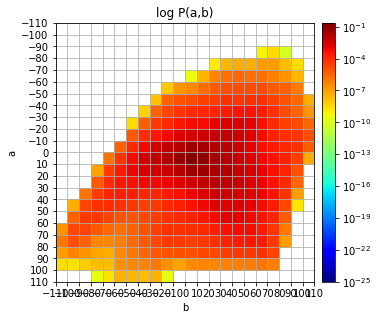

In [13]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

W = H = 10

cmap = cm.get_cmap('jet')

norm = colors.LogNorm(vmin=prior_probs.min()+1e-25,
                      vmax=prior_probs.max(),
                      clip=True)

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i in range(ab_grids.shape[0]):
    rect = patches.Rectangle((ab_grids[i,1], ab_grids[i,0]), W, H, color=m.to_rgba((prior_probs[i])))
    ax.add_patch(rect)

#ax.invert_yaxis()
ax.set_xlim([-110, 110]); ax.set_ylim([110, -110])
#ax.set_xticks([-110,-55,0,55,110]); ax.set_yticks([110,55,0,-55,-110])
ax.set_xticks(np.arange(-110,111,10)); ax.set_yticks(np.arange(110,-111,-10))
ax.set_xlabel('b'); ax.set_ylabel('a')
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.set_title('log P(a,b)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(m, cax=cax)

plt.show()

Text(0, 0.5, 'P(a,b)')

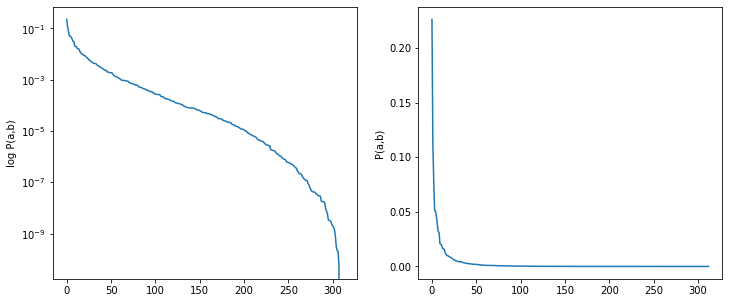

In [14]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)

ax.plot(np.sort(prior_probs)[::-1])
ax.set_yscale('log')
ax.set_ylabel('log P(a,b)')

ax = fig.add_subplot(122)

ax.plot(np.sort(prior_probs)[::-1])
ax.set_ylabel('P(a,b)')

In [32]:
torch.testing.assert_allclose(dists_torch, dists_torch2[:,:5])

### Debugging

In [19]:
query = np.c_[a.flatten(), b.flatten()]
print(ab_grids.shape, query.shape)
dist = np.linalg.norm(query[:,None,:] - ab_grids, axis=-1)
dist.shape

(313, 2) (272640, 2)


(272640, 313)

In [62]:
sorted_idx = np.argsort(dist, axis=1)
sorted_idx[0,:], sorted_idx.shape

(array([143, 124, 142, 123, 144, 125, 161, 106, 160, 105, 162, 141, 122,
        107, 145, 126, 159, 104, 180,  89, 179, 163, 108,  88, 181,  90,
        140, 121, 178,  87, 158, 146, 127, 103, 182,  91, 200, 164, 109,
         73, 199,  72, 201,  74, 177,  86, 139, 120, 198,  71, 183,  92,
        202, 157, 102,  75, 147, 128, 165, 110, 220, 197,  70,  57, 219,
        176,  85,  56, 221,  58, 203,  76, 218, 184, 138, 119,  93,  55,
        222,  59, 156, 101, 196, 148, 129,  69, 217,  54, 166, 111, 204,
        175,  84,  77, 240, 223,  60,  42, 239,  41, 241,  43, 185,  94,
        238,  40, 137, 118, 242, 216,  53,  44, 195,  68, 155, 100, 224,
         61, 237, 130,  39, 205,  78, 243, 174, 112,  83,  45, 260, 259,
         29, 261,  28, 215,  52,  30,  95, 236, 258,  38,  27, 194,  67,
        262, 136, 117,  62, 244,  31,  46, 154,  99, 257,  79,  26, 263,
         32, 173,  82, 235,  37, 214,  51, 280, 279, 256,  17, 281,  47,
         25,  16,  18,  63, 193,  66, 278, 264,  33

In [63]:
sorted_dist = np.take_along_axis(dist, sorted_idx, axis=1)
sorted_dist[0,:], sorted_dist.shape

(array([  5.00761902,   5.5428849 ,   9.56501258,   9.85579984,
         12.59615143,  12.8183601 ,  14.81313348,  15.37435845,
         16.90686668,  17.40069295,  18.7887122 ,  18.91831607,
         19.06698738,  19.23428398,  22.18670353,  22.31360881,
         23.500114  ,  23.85785683,  24.77461601,  25.33807851,
         26.08054478,  26.20310074,  26.52441259,  26.61637541,
         27.33803909,  27.84968591,  28.71090212,  28.80908234,
         30.76699585,  31.22250242,  31.91658778,  32.02868396,
         32.11672338,  32.1809035 ,  32.87788259,  33.30453104,
         34.75822599,  34.9312077 ,  35.17287656,  35.32230949,
         35.70080519,  36.25022434,  36.62951073,  37.16520321,
         37.59017492,  37.96390226,  38.60996138,  38.68302525,
         39.25507239,  39.75540193,  40.18136317,  40.5312049 ,
         40.93052454,  41.04974778,  41.25559074,  41.41061594,
         41.94548103,  42.01274454,  44.20153904,  44.39277   ,
         44.74915585,  44.8037267 ,  45.

In [ ]:
img_lab_arr = color.rgb2lab(img_rgb_arr)
#     print(img_lab_arr.shape, img_lab_arr.dtype)

l, a, b = img_lab_arr[...,0], img_lab_arr[...,1], img_lab_arr[...,2]
#     print(l.shape, a.shape, b.shape)
#     print(np.max(l), np.min(l),'\n', np.max(a), np.min(a),'\n', np.max(b), np.min(b))

dists, inds = nn_model.kneighbors(np.c_[a.flatten(), b.flatten()])

sigma = 5
wts = np.exp(-dists**2/(2*sigma**2))
#print(wts.shape)
wts /= np.sum(wts, axis=1)[:,None]

for i in range(ab_grids.shape[0]):
    prior_probs[i] += np.sum(wts[inds == i])

if ii == 100:
    break

In [13]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 5919),
             ('active.all.current', 8),
             ('active.all.freed', 5911),
             ('active.all.peak', 8),
             ('active.large_pool.allocated', 1056),
             ('active.large_pool.current', 6),
             ('active.large_pool.freed', 1050),
             ('active.large_pool.peak', 6),
             ('active.small_pool.allocated', 4863),
             ('active.small_pool.current', 2),
             ('active.small_pool.freed', 4861),
             ('active.small_pool.peak', 4),
             ('active_bytes.all.allocated', 46411089920),
             ('active_bytes.all.current', 6601839616),
             ('active_bytes.all.freed', 39809250304),
             ('active_bytes.all.peak', 7906265600),
             ('active_bytes.large_pool.allocated', 46256608256),
             ('active_bytes.large_pool.current', 6601834496),
             ('active_bytes.large_pool.freed', 39654773760),
             ('active_bytes.large_pool.peak', 79

In [64]:
dists_n, inds_n = sorted_dist[:,:5], sorted_idx[:,:5]

In [66]:
dists, inds = nn_model.kneighbors(np.c_[a.flatten(), b.flatten()])
np.testing.assert_allclose(dists_n, dists)
np.testing.assert_allclose(inds_n, inds)

In [72]:
dists_g, inds_g = knn(torch.Tensor(ab_grids), torch.Tensor(query), 5)
np.testing.assert_allclose(dists_g.cpu().detach().numpy(), dists)
np.testing.assert_allclose(inds_g.cpu().detach().numpy(), inds)

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 284921 / 1363200 (20.9%)
Max absolute difference: 3.30903418e-06
Max relative difference: 3.48121927e-05
 x: array([[ 5.007619,  5.542885,  9.565011,  9.855799, 12.596152],
       [ 3.847021,  6.542587,  9.362576, 10.754706, 11.913912],
       [ 3.815859,  6.621984,  9.26545 , 10.730258, 11.96967 ],...
 y: array([[ 5.007619,  5.542885,  9.565013,  9.8558  , 12.596151],
       [ 3.847021,  6.542586,  9.362577, 10.754706, 11.913912],
       [ 3.81586 ,  6.621984,  9.265447, 10.730257, 11.969672],...

## Compute Prior Probs (CPU)

In [16]:
import os
import glob

from tqdm import tqdm
from PIL import Image
import numpy as np
from skimage import color

In [17]:
img_dir = '/Colorization/data/val2017'
img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
len(img_paths)

5000

In [28]:
ab_grids = np.load('/Colorization/src/pts_in_hull.npy')
ab_grids.shape

(313, 2)

In [29]:
import sklearn.neighbors as nn
NN = 5
nn_model = nn.NearestNeighbors(n_neighbors=NN, algorithm='auto').fit(ab_grids)

In [36]:
dists, inds = nn_model.kneighbors(np.c_[a.flatten(), b.flatten()])
dists.shape, inds.shape

((272640, 5), (272640, 5))

In [51]:
arr = np.random.randint(10, size=(5,5))
arr, np.sort(arr, axis=1), np.argsort(arr, axis=1), np.flip(np.argsort(arr, axis=1),axis=1), np.take_along_axis(arr, np.argsort(arr, axis=1), axis=1)

(array([[7, 7, 9, 1, 2],
        [0, 4, 6, 6, 6],
        [2, 9, 9, 3, 2],
        [1, 7, 3, 9, 4],
        [3, 4, 3, 9, 2]]),
 array([[1, 2, 7, 7, 9],
        [0, 4, 6, 6, 6],
        [2, 2, 3, 9, 9],
        [1, 3, 4, 7, 9],
        [2, 3, 3, 4, 9]]),
 array([[3, 4, 0, 1, 2],
        [0, 1, 2, 3, 4],
        [0, 4, 3, 1, 2],
        [0, 2, 4, 1, 3],
        [4, 0, 2, 1, 3]]),
 array([[2, 1, 0, 4, 3],
        [4, 3, 2, 1, 0],
        [2, 1, 3, 4, 0],
        [3, 1, 4, 2, 0],
        [3, 1, 2, 0, 4]]),
 array([[1, 2, 7, 7, 9],
        [0, 4, 6, 6, 6],
        [2, 2, 3, 9, 9],
        [1, 3, 4, 7, 9],
        [2, 3, 3, 4, 9]]))

In [48]:
np.c_[a.flatten(), b.flatten()][10], inds[10], dists[10]

(array([ 2.55359542, 40.75039044]),
 array([124, 143, 125, 123, 144]),
 array([ 2.66156634,  7.48411832,  9.5956306 , 11.0495133 , 11.87451971]))

In [54]:
sigma = 5
wts = np.exp(-dists**2/(2*sigma**2))
print(wts.shape)
wts /= np.sum(wts, axis=1)[:,None]
wts[10]

# wts: each pixel's contribution to ab weights

(272640, 5)


array([0.57887822, 0.2175721 , 0.10576803, 0.0580286 , 0.03975305])

In [43]:
np.sum(wts, axis=1)[:,None].shape

(272640, 1)

In [47]:
prior_probs = np.zeros((ab_grids.shape[0]))
prior_probs.shape

(313,)

In [18]:
prior_probs = np.zeros((ab_grids.shape[0]))

for ii, img_path in enumerate(tqdm(img_paths)):
    img_rgb_arr = np.array(Image.open(img_path))
#     print(img_rgb_arr.shape, img_rgb_arr.dtype)
    assert img_rgb_arr.dtype == 'uint8'
    print(img_path)
    
    img_lab_arr = color.rgb2lab(img_rgb_arr)
#     print(img_lab_arr.shape, img_lab_arr.dtype)
    
    l, a, b = img_lab_arr[...,0], img_lab_arr[...,1], img_lab_arr[...,2]
#     print(l.shape, a.shape, b.shape)
#     print(np.max(l), np.min(l),'\n', np.max(a), np.min(a),'\n', np.max(b), np.min(b))
    
    dists, inds = nn_model.kneighbors(np.c_[a.flatten(), b.flatten()])
    
    sigma = 5
    wts = np.exp(-dists**2/(2*sigma**2))
    #print(wts.shape)
    wts /= np.sum(wts, axis=1)[:,None]
    
    for i in range(ab_grids.shape[0]):
        prior_probs[i] += np.sum(wts[inds == i])
    
    if ii == 0:
        break
        
prior_probs /= np.sum(prior_probs)
np.sum(prior_probs)

  0%|          | 0/5000 [00:00<?, ?it/s]

/Colorization/data/val2017/000000000139.jpg


  0%|          | 0/5000 [00:00<?, ?it/s]


1.0000000000000002

In [50]:
prior_probs[inds] = wts

In [55]:
prior_probs[124]

0.49226033460049506

In [58]:
np.arange(ab_grids.shape[0]).shape

(313,)

In [69]:
(inds[...,None] == np.arange(ab_grids.shape[0])[None,...]).shape

(272640, 5, 313)

In [64]:
np.sum(inds == 120)

64558

In [74]:
(np.repeat(wts[...,None], 313, axis=-1)[inds[...,None] == np.arange(ab_grids.shape[0])[None,...]]).shape

(1363200,)

In [79]:
for i in range(313):
    prior_probs[i] = np.sum(wts[inds == i])
prior_probs /= np.sum(prior_probs)
np.sum(prior_probs)

1.0000000000000002

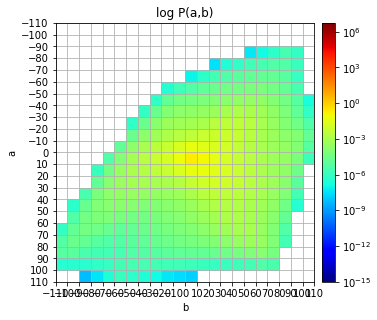

In [90]:
W = H = 10

cmap = cm.get_cmap('jet')

norm = colors.LogNorm(vmin=prior_probs.min()+1e-15,
                      vmax=prior_probs.max(),
                      clip=True)

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i in range(ab_grids.shape[0]):
    rect = patches.Rectangle((ab_grids[i,1], ab_grids[i,0]), W, H, color=m.to_rgba((prior_probs_ImageNet[i])))
    ax.add_patch(rect)

#ax.invert_yaxis()
ax.set_xlim([-110, 110]); ax.set_ylim([110, -110])
#ax.set_xticks([-110,-55,0,55,110]); ax.set_yticks([110,55,0,-55,-110])
ax.set_xticks(np.arange(-110,111,10)); ax.set_yticks(np.arange(110,-111,-10))
ax.set_xlabel('b'); ax.set_ylabel('a')
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.set_title('log P(a,b)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(m, cax=cax)

plt.show()

## Visualize Prior Probs

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6udo9ewe because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
ab_grids = np.load('/Colorization/src/pts_in_hull.npy')
ab_grids.shape

(313, 2)

In [3]:
prior_probs_ImageNet = np.load('/Colorization/src/prior_probs.npy')
prior_probs_ImageNet.shape, np.sum(prior_probs_ImageNet)

((313,), 0.9999999999999989)

In [16]:
img_paths

['/Colorization/data/val2017/000000000139.jpg',
 '/Colorization/data/val2017/000000000285.jpg',
 '/Colorization/data/val2017/000000000632.jpg',
 '/Colorization/data/val2017/000000000724.jpg',
 '/Colorization/data/val2017/000000000776.jpg',
 '/Colorization/data/val2017/000000000785.jpg',
 '/Colorization/data/val2017/000000000802.jpg',
 '/Colorization/data/val2017/000000000872.jpg',
 '/Colorization/data/val2017/000000000885.jpg',
 '/Colorization/data/val2017/000000001000.jpg',
 '/Colorization/data/val2017/000000001268.jpg',
 '/Colorization/data/val2017/000000001296.jpg',
 '/Colorization/data/val2017/000000001353.jpg',
 '/Colorization/data/val2017/000000001425.jpg',
 '/Colorization/data/val2017/000000001490.jpg',
 '/Colorization/data/val2017/000000001503.jpg',
 '/Colorization/data/val2017/000000001532.jpg',
 '/Colorization/data/val2017/000000001584.jpg',
 '/Colorization/data/val2017/000000001675.jpg',
 '/Colorization/data/val2017/000000001761.jpg',
 '/Colorization/data/val2017/00000000181

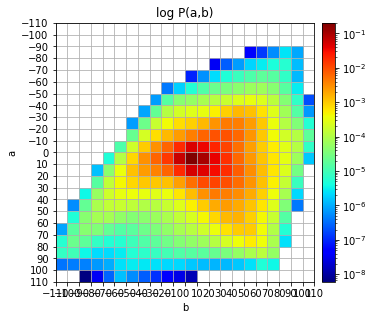

In [4]:
W = H = 10

cmap = cm.get_cmap('jet')

norm = colors.LogNorm(vmin=prior_probs_ImageNet.min(),
                      vmax=prior_probs_ImageNet.max(),
                      clip=True)

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i in range(ab_grids.shape[0]):
    rect = patches.Rectangle((ab_grids[i,1], ab_grids[i,0]), W, H, color=m.to_rgba((prior_probs_ImageNet[i])))
    ax.add_patch(rect)

#ax.invert_yaxis()
ax.set_xlim([-110, 110]); ax.set_ylim([110, -110])
#ax.set_xticks([-110,-55,0,55,110]); ax.set_yticks([110,55,0,-55,-110])
ax.set_xticks(np.arange(-110,111,10)); ax.set_yticks(np.arange(110,-111,-10))
ax.set_xlabel('b'); ax.set_ylabel('a')
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.set_title('log P(a,b)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(m, cax=cax)

plt.show()

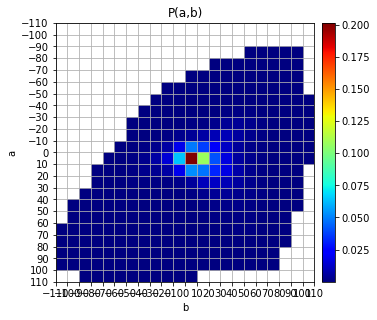

In [5]:
W = H = 10

cmap = cm.get_cmap('jet')

norm = colors.Normalize(vmin=prior_probs_ImageNet.min(),
                        vmax=prior_probs_ImageNet.max(),
                        clip=True)

m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i in range(ab_grids.shape[0]):
    rect = patches.Rectangle((ab_grids[i,1], ab_grids[i,0]), W, H, color=m.to_rgba((prior_probs_ImageNet[i])))
    ax.add_patch(rect)

#ax.invert_yaxis()
ax.set_xlim([-110, 110]); ax.set_ylim([110, -110])
#ax.set_xticks([-110,-55,0,55,110]); ax.set_yticks([110,55,0,-55,-110])
ax.set_xticks(np.arange(-110,111,10)); ax.set_yticks(np.arange(110,-111,-10))
ax.set_xlabel('b'); ax.set_ylabel('a')
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.set_title('P(a,b)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
fig.colorbar(m, cax=cax)

plt.show()

Text(0, 0.5, 'P(a,b)')

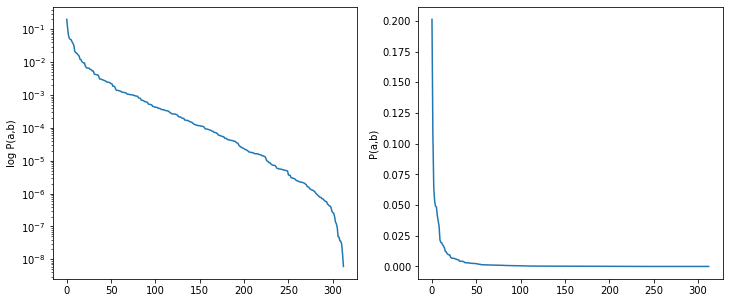

In [6]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)

ax.plot(np.sort(prior_probs_ImageNet)[::-1])
ax.set_yscale('log')
ax.set_ylabel('log P(a,b)')

ax = fig.add_subplot(122)

ax.plot(np.sort(prior_probs_ImageNet)[::-1])
ax.set_ylabel('P(a,b)')

In [50]:
a[20], b[16]

(-90, 50)

In [34]:
np.flatnonzero(x == ab_grids[0,0])

array([2])

In [76]:
inds == 1

array([[False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       ...,
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])

In [30]:
ab_grids[0,0]

-90

In [7]:
W = H = 10

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

for i in range(ab_grids.shape[0]):
    rect = patches.Rectangle((ab_grids[i,1], ab_grids[i,0]), W, H)
    ax.add_patch(rect)
# plt.plot(b, a, 'o')
ax.invert_yaxis()
ax.set_xlim([-110, 110]); ax.set_ylim([110, -110])
#ax.set_xticks([-110,-55,0,55,110]); ax.set_yticks([110,55,0,-55,-110])
ax.set_xticks(np.arange(-110,111,10)); ax.set_yticks(np.arange(110,-111,-10))
ax.set_xlabel('b'); ax.set_ylabel('a')
ax.grid()
ax.set_aspect('equal', adjustable='box')

plt.show()

0.9999999999999989

In [ ]:
plt.color

In [39]:
bb,aa

(array([[-110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,
            0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
          110],
        [-110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,
            0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
          110],
        [-110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,
            0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
          110],
        [-110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,
            0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
          110],
        [-110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,
            0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
          110],
        [-110, -100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,
            0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
          110],
    

ValueError: not enough values to unpack (expected 2, got 1)

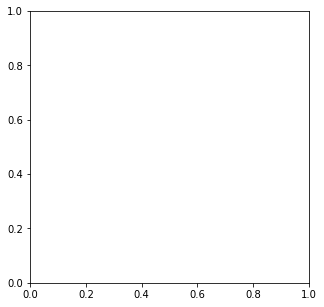

In [14]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)

# for i in range(ab_grids.shape[0]):
    #rect = patches.Rectangle((ab_grids[i,1], ab_grids[i,0]), W, H)
ax.pcolormesh(ab_grids[:,1], ab_grids[:,0], prior_probs_ImageNet, shading='gouraud')

In [19]:
ab_grids[:,0] == y

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False